#Deep features using scikit-learn

In [4]:
import sframe as sf

##Carregando os dados
A base utilizada será a CIFAR-10 com apenas 4 categorias (cat, dog, automobile, bird). Os dados também já estão separados entre treino e teste.

In [6]:
image_train = sf.SFrame('image_train_data/')
image_test = sf.SFrame('image_test_data/')

2016-04-25 07:45:20,535 [INFO] sframe.cython.cy_server, 172: SFrame v1.8.5 started. Logging C:\Users\PIETER~1.VOL\AppData\Local\Temp\sframe_server_1461581119.log.0


##Explorando os dados
Bem, começamos com o primeiro desafio: apresentar as imagens sem o método `SFrame.show()`. Vamos tentar usando a biblioteca scipy.

###Mostrando imagens com scipy

In [173]:
import scipy.misc as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

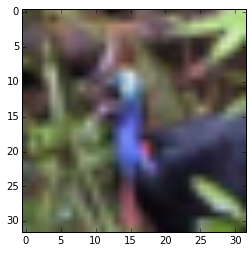

In [265]:
plt.imshow(sm.toimage(image_train[0]['image'].pixel_data))

voilà!

###Criando função para conversão de lista de imagens do SFrame

In [262]:
def show_images(sf_images):
    imgs = [np.uint8(sm.toimage(row['image'].pixel_data)) for row in sf_images]
    
    titles = [row['label'] for row in sf_images]
    white_img = np.uint8(sm.toimage(255 - sf_images[0]['image'].pixel_data * 0))
        
    total = min(len(imgs), 20)
    nrows = 1 if total <= 10 else 2
    ncols = min(total, 10)
        
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(100. * ncols / 72.)
    fig.set_figheight(100. * nrows / 72.)
        
    if nrows == 1 and ncols == 1:
        axes.axis('off')
        axes.set_title(titles[0])
        axes.imshow(imgs[0])
    elif nrows == 1:
        for i in xrange(total):
            axes[i].axis('off')
            axes[i].set_title(titles[i])
            axes[i].imshow(imgs[i])
    else:
        for j in xrange(10):
            for i in xrange(2):
                index = i * 10 + j
                axes[i, j].axis('off')
                axes[i, j].set_title(titles[index])
                axes[i, j].imshow(imgs[index] if index < total else white_img)

    plt.tight_layout()

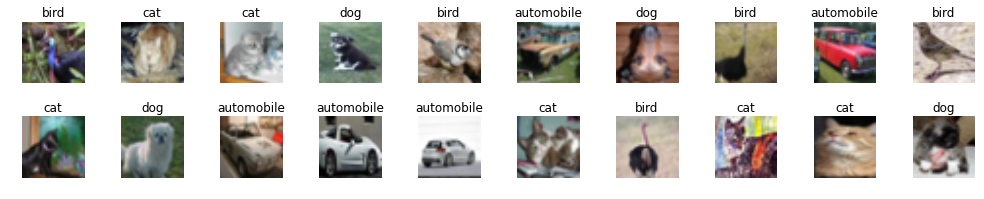

In [263]:
show_images(image_train[0:20])

Voilà!

##Treinando um classificador baseado nos pixels das imagens

In [268]:
np.asarray(image_train[0]['image_array']).shape

(3072L,)

In [440]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        if type(data) is sf.SFrame:
            result = data.to_dataframe()[self.features]
        else:
            result = data[self.features]
        
        return result
    
class ListTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, prefix='item', prefix_sep='_'):
        self.prefix = prefix
        self.prefix_sep = prefix_sep
        self.columns = []

    def fit(self, x, y=None):
        prefix = self.prefix + self.prefix_sep
        sufix_len = len(str(len(x[0])))
        self.columns = [prefix + str(i).zfill(sufix_len) for i in xrange(len(x[0]))]
        return self

    def transform(self, data):
        result = pd.DataFrame(data=data.values.tolist(), columns=self.columns)
        return result     

In [441]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import *

In [442]:
raw_pixel_model = Pipeline([
        ('features', Pipeline([
                    ('image_array', ColumnSelector('image_array')),
                    ('pixel_columns', ListTransformer(prefix='pixel'))
            ])),
        ('logistic_model', LogisticRegression())   
    ])

In [443]:
image_train['label_encoded'] = image_train.apply(lambda r: ['automobile', 'bird', 'cat', 'dog'].index(r['label']))

In [448]:
raw_pixel_model.fit(image_train, image_train['label'])

Pipeline(steps=[('features', Pipeline(steps=[('image_array', ColumnSelector(features='image_array')), ('pixel_columns', ListTransformer(prefix='pixel', prefix_sep='_'))])), ('logistic_model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

###Fazendo previsões com o modelo por pixels

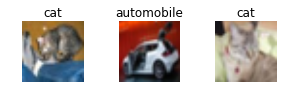

In [449]:
show_images(image_test[0:3])

In [450]:
raw_pixel_model.predict(image_test[0:3])

array(['dog', 'cat', 'dog'], 
      dtype='|S10')

###Avaliando o modelo por pixels

In [451]:
raw_pixel_pred_class = raw_pixel_model.predict(image_test)
raw_pixel_pred_prob = raw_pixel_model.predict_proba(image_test)[:, 1]

In [454]:
from sklearn import metrics
print metrics.accuracy_score(np.array(image_test['label']), raw_pixel_pred_class)

0.4015


##Treinando um modelo com base em deep features

In [455]:
deep_features_model = Pipeline([
        ('features', Pipeline([
                    ('deep_features', ColumnSelector('deep_features')),
                    ('features_columns', ListTransformer(prefix='feat'))
            ])),
        ('logistic_model', LogisticRegression())   
    ])

In [456]:
deep_features_model.fit(image_train, image_train['label'])

Pipeline(steps=[('features', Pipeline(steps=[('deep_features', ColumnSelector(features='deep_features')), ('features_columns', ListTransformer(prefix='feat', prefix_sep='_'))])), ('logistic_model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

###Avaliando o modelo

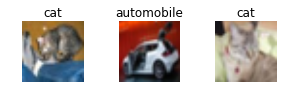

In [457]:
show_images(image_test[0:3])

In [458]:
deep_features_model.predict(image_test[0:3])

array(['cat', 'automobile', 'cat'], 
      dtype='|S10')

###Avaliando o modelo por deep features

In [459]:
deep_features_pred_class = deep_features_model.predict(image_test)
print metrics.accuracy_score(np.array(image_test['label']), deep_features_pred_class)

0.79825


##Criando um modelo de pesquisa

In [468]:
from sklearn.neighbors import NearestNeighbors

features = Pipeline([
                ('deep_features', ColumnSelector('deep_features')),
                ('features_columns', ListTransformer(prefix='feat'))
        ])

In [594]:
class DeepFeaturesKnn():
    
    def __init__(self, dataset, features, label):
        self.dataset = dataset
        self.features = features
        self.label = label
        self.knn_model = self._init_model()
        
    def _init_model(self):
        model = NearestNeighbors(n_neighbors=5)
        model.fit(self.features.fit_transform(self.dataset))
        return model
    
    def query(self, select, k=5):
        distances, indexes = self.knn_model.kneighbors(self.features.transform(select), n_neighbors=k, return_distance=True)

        result = sf.SFrame()
        result['query_label'] = [0 for v in xrange(len(indexes[0]))]
        result['reference_label'] = np.array(self.dataset['id'])[indexes][0]
        result['distance'] = distances[0]
        result['rank'] = range(1, len(indexes[0]) + 1)
        
        for i in xrange(1, len(indexes)):
            result_i = sf.SFrame()
            result_i['query_label'] = [i for v in xrange(len(indexes[i]))]
            result_i['reference_label'] = np.array(self.dataset['id'])[indexes][i]
            result_i['distance'] = distances[i]
            result_i['rank'] = range(1, len(indexes[i]) + 1)
            result = result.append(result_i)
            
        return result

In [595]:
knn_model = DeepFeaturesKnn(image_train, features=features, label='id')

###Usando o modelo para fazer algumas pesquisas

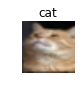

In [597]:
cat = image_train[18:19]
show_images(cat)

In [598]:
knn_model.query(cat)

query_label,reference_label,distance,rank
0,384,0.0,1
0,6910,36.9403137951,2
0,39777,38.4634888975,3
0,36870,39.7559623119,4
0,41734,39.7866014148,5


In [544]:
def get_images_from_ids(query_result):
    return image_train.filter_by(query_result['reference_label'], 'id')

In [545]:
cat_neighbors = get_images_from_ids(knn_model.query(cat))

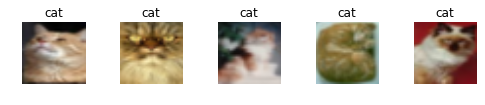

In [546]:
show_images(cat_neighbors)

###Procurando carros similares

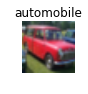

In [547]:
car = image_train[8:9]
show_images(car)

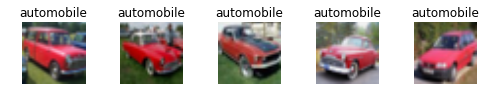

In [549]:
show_images(get_images_from_ids(knn_model.query(car)))

##Criando função lambda

In [550]:
show_neighbors = lambda i: show_images(get_images_from_ids(knn_model.query(image_train[i:i+1])))

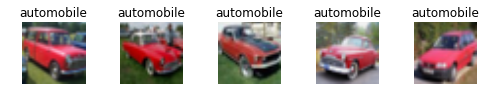

In [551]:
show_neighbors(8)

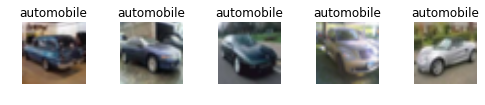

In [552]:
show_neighbors(26)

##Exercícios
###Exercício 1

In [553]:
image_train['label'].sketch_summary()


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  2005 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   4   |    No    |
+------------------+-------+----------+

Most frequent items:
+-------+------------+-----+-----+------+
| value | automobile | cat | dog | bird |
+-------+------------+-----+-----+------+
| count |    509     | 509 | 509 | 478  |
+-------+------------+-----+-----+------+


###Exercício 2

In [599]:
categories = ['dog', 'cat', 'automobile', 'bird']
categorized_knn_models = {}
for category in categories:
    subset = image_train[image_train['label'] == category]    
    categorized_knn_models[category] = DeepFeaturesKnn(subset, features=features, label='id')

In [573]:
cat = image_test[0:1]

In [574]:
categorized_knn_models['cat'].query(cat)

query_label,reference_label,distance,rank
0,16289,34.623719208,1
0,45646,36.0068799284,2
0,32139,36.5200813436,3
0,25713,36.7548502521,4
0,331,36.8731228168,5


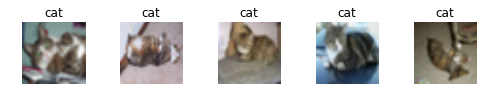

In [575]:
show_images(get_images_from_ids(categorized_knn_models['cat'].query(cat)))

In [576]:
categorized_knn_models['dog'].query(cat)

query_label,reference_label,distance,rank
0,16976,37.4642628784,1
0,13387,37.5666832169,2
0,35867,37.6047267079,3
0,44603,37.7065585153,4
0,6094,38.5113254907,5


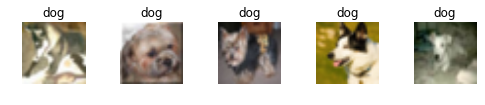

In [577]:
show_images(get_images_from_ids(categorized_knn_models['dog'].query(cat)))

###Exercício 3

In [578]:
print 'mean distance with cat knn: %s' % (categorized_knn_models['cat'].query(cat)['distance'].mean())

mean distance with cat knn: 36.1557307098


In [579]:
print 'mean distance with dog knn: %s' % (categorized_knn_models['dog'].query(cat)['distance'].mean())

mean distance with dog knn: 37.7707113618


###Exercício 4

In [580]:
categorized_image_test = {}
for category in categories:
    categorized_image_test[category] = image_test[image_test['label'] == category]

In [600]:
dog_dog_neighbors = categorized_knn_models['dog'].query(categorized_image_test['dog'], k=1)
dog_cat_neighbors = categorized_knn_models['cat'].query(categorized_image_test['dog'], k=1)
dog_automobile_neighbors = categorized_knn_models['automobile'].query(categorized_image_test['dog'], k=1)
dog_bird_neighbors = categorized_knn_models['bird'].query(categorized_image_test['dog'], k=1)

In [601]:
dog_distances = sf.SFrame({'dog-dog': dog_dog_neighbors['distance'],
                           'dog-cat': dog_cat_neighbors['distance'],
                           'dog-automobile': dog_automobile_neighbors['distance'],
                           'dog-bird': dog_bird_neighbors['distance']})

In [602]:
dog_distances

dog-automobile,dog-bird,dog-cat,dog-dog
41.9579761457,41.7538647304,36.4196077068,33.4773590373
46.0021331807,41.3382958925,38.8353268874,32.8458495684
42.9462290692,38.6157590853,36.9763410854,35.0397073189
41.6866060048,37.0892269954,34.5750072914,33.9010327697
39.2269664935,38.272288694,34.778824791,37.4849250909
40.5845117698,39.1462089236,35.1171578292,34.945165344
45.1067352961,40.523040106,40.6095830913,39.0957278345
41.3221140974,38.1947918393,39.9036867306,37.7696131032
41.8244654995,40.1567131661,38.0674700168,35.1089144603
45.4976929401,45.5597962603,42.7258732951,43.2422832585


In [603]:
def is_dog_correct(row):
    return row['dog-dog'] < min(row['dog-cat'], row['dog-automobile'], row['dog-bird'])

In [604]:
print dog_distances.apply(is_dog_correct).sum()

678


In [605]:
print 'accuracy: %s' % (dog_distances.apply(is_dog_correct).sum() / float(len(dog_distances)))

accuracy: 0.678
